In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

from scipy import stats

# optional (회귀/robust SE)
import statsmodels.api as sm
import statsmodels.formula.api as smf

SEED = 0
rng = np.random.default_rng(SEED)

ROOT = Path(".")
EXT = ".png"

# 대표 샘플(MetalSet 대표 271)
REP_CSV = ROOT / "manifest_MetalSet_rep271_PCA_UMAP_KMeans.csv"
SET_B = "StdMetal"   # StdMetal는 폴더에서 manifest 생성


In [4]:
def list_ids(set_dir: Path, mod: str) -> set:
    paths = list((set_dir / mod).rglob(f"*{EXT}"))
    return {p.stem for p in paths}

def build_manifest(set_name: str, mod="target") -> pd.DataFrame:
    set_dir = ROOT / set_name
    if not set_dir.exists():
        raise RuntimeError(f"Dataset dir not found: {set_dir.resolve()}")

    ids = sorted(list_ids(set_dir, mod))
    if len(ids) == 0:
        raise RuntimeError(f"No files found: {set_dir/mod} (*{EXT})")

    return pd.DataFrame({
        "set": set_name,
        "base_id": ids,
        mod: [str(set_dir / mod / f"{i}{EXT}") for i in ids]
    })

# MetalSet 대표 csv
if not REP_CSV.exists():
    raise RuntimeError(f"Representative CSV not found: {REP_CSV.resolve()}")
man_metal_rep = pd.read_csv(REP_CSV)
if "target" not in man_metal_rep.columns:
    raise RuntimeError("rep csv must contain 'target' column")

man_metal_rep["set"] = "MetalSet_rep"

# StdMetal target 전체
man_std = build_manifest(SET_B, mod="target")
man_std["set"] = "StdMetal"

print("MetalSet_rep:", len(man_metal_rep))
print("StdMetal:", len(man_std))
man_metal_rep.head()


MetalSet_rep: 271
StdMetal: 271


,set,base_id,target,cluster
0,MetalSet_rep,cell4130,c:\Users\권나연\Desktop\나연\연세대학교\DSL\26-1\EDA\lit...,0
1,MetalSet_rep,cell2675,c:\Users\권나연\Desktop\나연\연세대학교\DSL\26-1\EDA\lit...,0
2,MetalSet_rep,cell15250,c:\Users\권나연\Desktop\나연\연세대학교\DSL\26-1\EDA\lit...,1
3,MetalSet_rep,cell9201,c:\Users\권나연\Desktop\나연\연세대학교\DSL\26-1\EDA\lit...,2
4,MetalSet_rep,cell14893,c:\Users\권나연\Desktop\나연\연세대학교\DSL\26-1\EDA\lit...,2


In [5]:
DS_SIZE = 256

def load_gray01(path: str) -> np.ndarray:
    im = Image.open(path).convert("L")
    arr = np.asarray(im, dtype=np.float32) / 255.0
    return arr

def downsample_nearest(bin_img: np.ndarray, size=256) -> np.ndarray:
    pil = Image.fromarray((bin_img * 255).astype(np.uint8))
    pil = pil.resize((size, size), resample=Image.NEAREST)
    return (np.asarray(pil) > 0).astype(np.uint8)

def otsu_threshold(arr01: np.ndarray) -> float:
    img = (arr01 * 255).astype(np.uint8)
    hist = np.bincount(img.ravel(), minlength=256).astype(np.float64)
    total = img.size
    sum_total = np.dot(np.arange(256), hist)

    sumB, wB = 0.0, 0.0
    max_var, thresh = -1.0, 127
    for t in range(256):
        wB += hist[t]
        if wB == 0:
            continue
        wF = total - wB
        if wF == 0:
            break
        sumB += t * hist[t]
        mB = sumB / wB
        mF = (sum_total - sumB) / wF
        var_between = wB * wF * (mB - mF) ** 2
        if var_between > max_var:
            max_var = var_between
            thresh = t

    thr = thresh / 255.0

    # ---- 안전장치: thr이 0/1로 붕괴하면 0.5로 fallback
    eps = 1.0 / 255.0
    if thr <= eps or thr >= (1.0 - eps):
        thr = 0.5
    return float(thr)

def binarize_auto(arr01: np.ndarray, thr=None, auto_invert=True):
    if thr is None:
        thr = otsu_threshold(arr01)
    b = (arr01 >= thr).astype(np.uint8)

    if not auto_invert:
        return b, float(thr), False

    frac = float(b.mean())
    # 팀원 로직: 극단일 때만 invert 비교
    if frac < 0.01 or frac > 0.99:
        b_inv = 1 - b
        frac_inv = float(b_inv.mean())
        def score(f): return -abs(f - 0.5)
        if score(frac_inv) > score(frac):
            return b_inv, float(thr), True

    return b, float(thr), False

def load_bin_target(path: str, size=DS_SIZE):
    g = load_gray01(path)
    b, thr, inv = binarize_auto(g, thr=None, auto_invert=True)
    b = downsample_nearest(b, size=size)
    return b, thr, inv


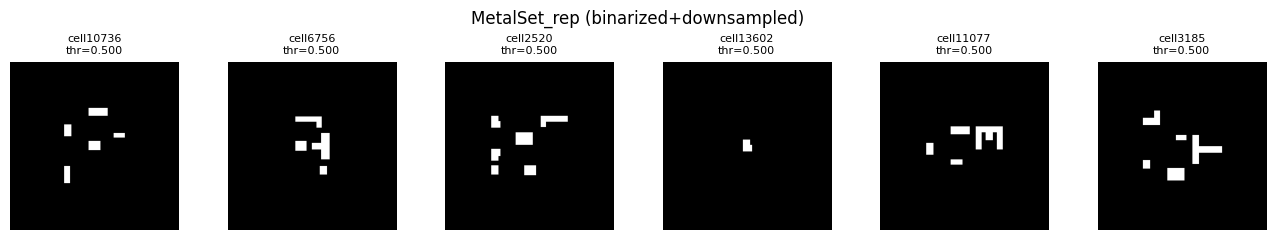

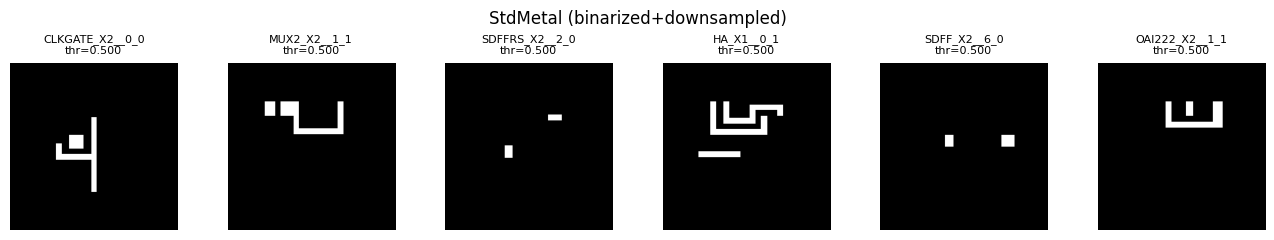

In [6]:
def show_random_targets(df, k=6, title=""):
    samp = df.sample(min(k, len(df)), random_state=SEED)
    fig, axes = plt.subplots(1, len(samp), figsize=(2.2*len(samp), 2.4))
    if len(samp) == 1:
        axes = [axes]
    for ax, (_, r) in zip(axes, samp.iterrows()):
        b, thr, inv = load_bin_target(r["target"])
        ax.imshow(b, cmap="gray")
        ax.set_title(f"{r.get('base_id','')}\nthr={thr:.3f}", fontsize=8)
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_random_targets(man_metal_rep, 6, "MetalSet_rep (binarized+downsampled)")
show_random_targets(man_std, 6, "StdMetal (binarized+downsampled)")


In [7]:
try:
    import scipy.ndimage as ndi
    def count_components(mask01):
        struct = np.ones((3,3), dtype=np.uint8)  # 8-neighborhood
        _, n = ndi.label(mask01.astype(np.uint8), structure=struct)
        return int(n)
except ImportError:
    raise ImportError("scipy가 필요합니다. (pip install scipy)")

def edge_map(mask01):
    m = mask01.astype(np.uint8)
    gx = np.abs(np.diff(m, axis=1, prepend=m[:, :1]))
    gy = np.abs(np.diff(m, axis=0, prepend=m[:1, :]))
    return ((gx + gy) > 0).astype(np.uint8)

def entropy(arr01, bins=64):
    hist, _ = np.histogram(arr01.ravel(), bins=bins, range=(0.0, 1.0), density=False)
    p = hist.astype(np.float64)
    p = p / (p.sum() + 1e-12)
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum())

def complexity_metrics(target_path):
    g = load_gray01(target_path)
    # grayscale
    ent = entropy(g, bins=64)
    gx = np.abs(np.diff(g, axis=1, prepend=g[:, :1]))
    gy = np.abs(np.diff(g, axis=0, prepend=g[:1, :]))
    grad_mean = float((gx + gy).mean())

    # binary
    b, thr, inv = binarize_auto(g, thr=None, auto_invert=True)
    b = downsample_nearest(b, size=DS_SIZE)

    area_frac = float(b.mean())
    e = edge_map(b)
    edge_density = float(e.mean())
    perimeter = int(e.sum())
    area = int(b.sum())
    compactness = float((perimeter**2) / (area + 1e-12))
    comps = count_components(b)

    return {
        "thr": float(thr),
        "invert": bool(inv),
        "entropy(gray)": ent,
        "mean_grad(gray)": grad_mean,
        "area_frac(bin)": area_frac,
        "edge_density(bin)": edge_density,
        "perimeter_px(bin)": perimeter,
        "compactness(peri^2/area)": compactness,
        "components(bin)": int(comps),
    }

def build_metrics_df(df, label_name):
    rows = []
    for i, r in df.iterrows():
        m = complexity_metrics(r["target"])
        m["set"] = label_name
        m["base_id"] = r.get("base_id", f"idx_{i}")
        rows.append(m)
        if (i+1) % 50 == 0:
            print(f"[{label_name}] {i+1}/{len(df)}")
    return pd.DataFrame(rows)

metrics_metal = build_metrics_df(man_metal_rep, "MetalSet_rep")
metrics_std   = build_metrics_df(man_std, "StdMetal")
metrics_all = pd.concat([metrics_metal, metrics_std], ignore_index=True)

metrics_all.head()


[MetalSet_rep] 50/271
[MetalSet_rep] 100/271
[MetalSet_rep] 150/271
[MetalSet_rep] 200/271
[MetalSet_rep] 250/271
[StdMetal] 50/271
[StdMetal] 100/271
[StdMetal] 150/271
[StdMetal] 200/271
[StdMetal] 250/271


,thr,invert,entropy(gray),mean_grad(gray),area_frac(bin),edge_density(bin),perimeter_px(bin),compactness(peri^2/area),components(bin),set,base_id
0,0.5,False,0.180350,0.000863,0.027573,0.006866,450,112.064195,5,MetalSet_rep,cell4130
1,0.5,False,0.155354,0.000757,0.022583,0.006012,394,104.889189,5,MetalSet_rep,cell2675
2,0.5,False,0.142724,0.000640,0.021042,0.005096,334,80.896302,3,MetalSet_rep,cell15250
3,0.5,False,0.084194,0.000358,0.011612,0.002945,193,48.947438,3,MetalSet_rep,cell9201
4,0.5,False,0.063890,0.000248,0.007492,0.001953,128,33.368635,2,MetalSet_rep,cell14893


In [8]:
def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    na, nb = len(a), len(b)
    va, vb = a.var(ddof=1), b.var(ddof=1)
    sp = np.sqrt(((na-1)*va + (nb-1)*vb) / (na+nb-2) + 1e-12)
    return float((a.mean() - b.mean()) / sp)

def cliffs_delta(a, b):
    # O(n^2)지만 n=271이면 OK
    a = np.asarray(a); b = np.asarray(b)
    gt = 0; lt = 0
    for x in a:
        gt += np.sum(x > b)
        lt += np.sum(x < b)
    return float((gt - lt) / (len(a)*len(b)))

def fdr_bh(pvals):
    pvals = np.asarray(pvals)
    n = len(pvals)
    order = np.argsort(pvals)
    ranked = pvals[order]
    adj = np.empty(n, dtype=float)
    prev = 1.0
    for i in range(n-1, -1, -1):
        rank = i+1
        val = ranked[i] * n / rank
        prev = min(prev, val)
        adj[i] = prev
    out = np.empty(n, dtype=float)
    out[order] = np.clip(adj, 0, 1)
    return out

def run_tests(df, col):
    a = df[df["set"]=="MetalSet_rep"][col].dropna().values
    b = df[df["set"]=="StdMetal"][col].dropna().values

    mwu = stats.mannwhitneyu(a, b, alternative="two-sided")
    ks  = stats.ks_2samp(a, b, alternative="two-sided", mode="auto")

    return {
        "metric": col,
        "mean_metal": float(np.mean(a)),
        "mean_std": float(np.mean(b)),
        "diff_mean(metal-std)": float(np.mean(a) - np.mean(b)),
        "p_mwu": float(mwu.pvalue),
        "p_ks": float(ks.pvalue),
        "cohens_d": cohens_d(a, b),
        "cliffs_delta": cliffs_delta(a, b)
    }

cols_step1 = [
    "compactness(peri^2/area)",   # 네가 말한 layout_perim_area proxy로 가장 가깝게 대응
    "area_frac(bin)",             # layout_density
    "edge_density(bin)",
    "components(bin)",
    "entropy(gray)",
    "mean_grad(gray)"
]

res1 = pd.DataFrame([run_tests(metrics_all, c) for c in cols_step1])

# FDR separately for MWU/KS
res1["p_mwu_fdr"] = fdr_bh(res1["p_mwu"].values)
res1["p_ks_fdr"]  = fdr_bh(res1["p_ks"].values)

res1.sort_values("p_mwu").reset_index(drop=True)


,metric,mean_metal,mean_std,diff_mean(metal-std),p_mwu,p_ks,cohens_d,cliffs_delta,p_mwu_fdr,p_ks_fdr
0,components(bin),3.878229,2.819188,1.059041,7.628015e-25,4.679689e-23,0.809991,0.492695,4.576809e-24,2.807813e-22
1,entropy(gray),0.161774,0.200577,-0.038803,1.132934e-04,1.772009e-05,-0.447596,-0.191650,3.258203e-04,3.544018e-05
2,area_frac(bin),0.024734,0.033547,-0.008813,1.629101e-04,1.772009e-05,-0.477004,-0.187198,3.258203e-04,3.544018e-05
3,compactness(peri^2/area),99.873319,99.497701,0.375618,2.371570e-02,7.940968e-04,0.007129,0.112294,3.557355e-02,7.940968e-04
4,edge_density(bin),0.006120,0.007081,-0.000962,3.319784e-01,2.749420e-04,-0.257337,-0.048175,3.454133e-01,4.124130e-04
5,mean_grad(gray),0.000773,0.000892,-0.000119,3.454133e-01,3.945356e-04,-0.253636,-0.046854,3.454133e-01,4.734427e-04


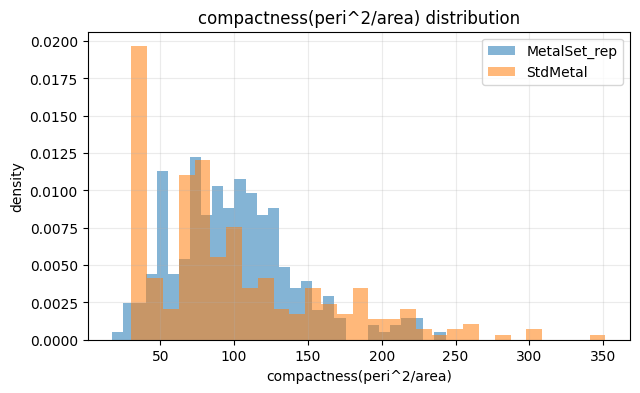

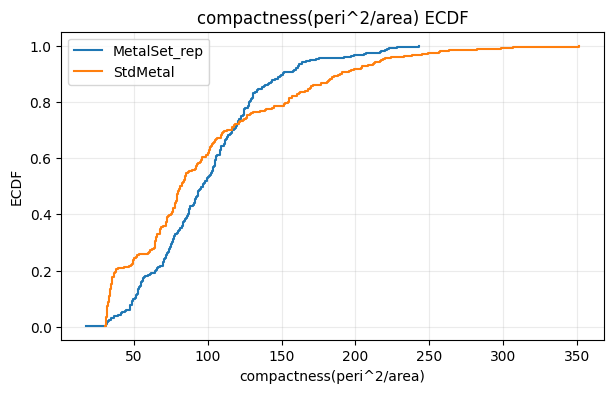

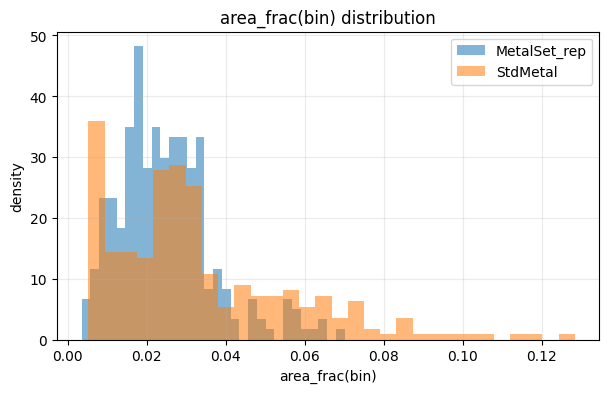

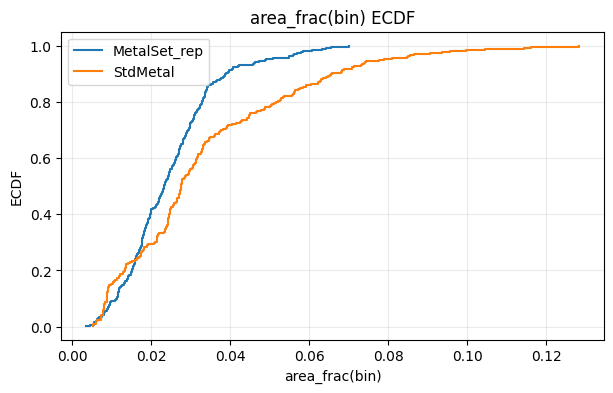

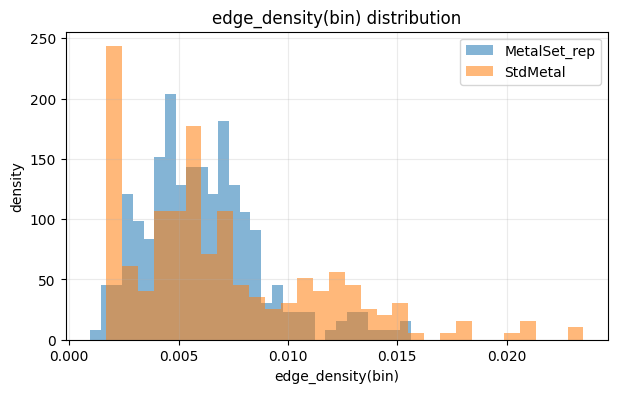

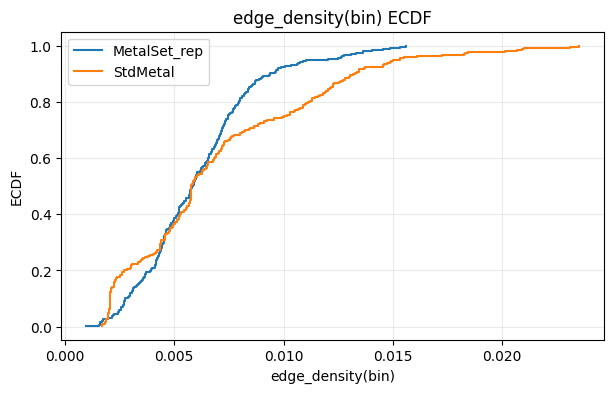

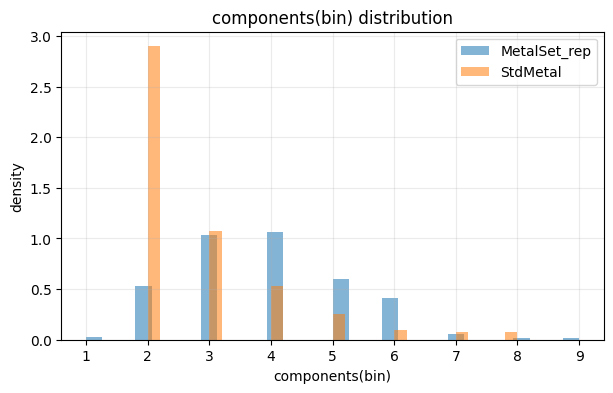

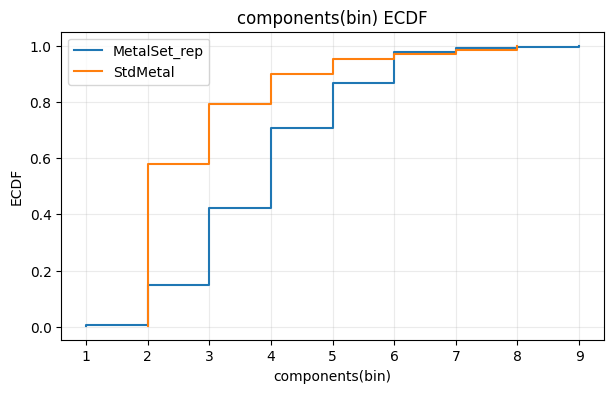

In [9]:
def plot_hist_overlay(df, col, bins=30, title=""):
    a = df[df["set"]=="MetalSet_rep"][col].values
    b = df[df["set"]=="StdMetal"][col].values
    plt.figure(figsize=(7,4))
    plt.hist(a, bins=bins, alpha=0.55, label="MetalSet_rep", density=True)
    plt.hist(b, bins=bins, alpha=0.55, label="StdMetal", density=True)
    plt.title(title or f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("density")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

def plot_ecdf(df, col, title=""):
    plt.figure(figsize=(7,4))
    for name in ["MetalSet_rep", "StdMetal"]:
        x = np.sort(df[df["set"]==name][col].values)
        y = np.arange(1, len(x)+1) / len(x)
        plt.step(x, y, where="post", label=name)
    plt.title(title or f"ECDF: {col}")
    plt.xlabel(col); plt.ylabel("ECDF")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

for col in ["compactness(peri^2/area)", "area_frac(bin)", "edge_density(bin)", "components(bin)"]:
    plot_hist_overlay(metrics_all, col, bins=30, title=f"{col} distribution")
    plot_ecdf(metrics_all, col, title=f"{col} ECDF")


## Step2

In [10]:
STAGES = ["target", "litho", "resist", "printed"]  # 폴더명이 실제와 다르면 수정

def build_manifest_multi(set_name: str, stages=STAGES) -> pd.DataFrame:
    set_dir = ROOT / set_name
    if not set_dir.exists():
        raise RuntimeError(f"Dataset dir not found: {set_dir.resolve()}")

    id_sets = {s: list_ids(set_dir, s) for s in stages}
    common = set.intersection(*[id_sets[s] for s in stages])
    if len(common) == 0:
        raise RuntimeError(f"{set_name}: no common ids across stages={stages}")

    rows = []
    for bid in sorted(common):
        row = {"set": set_name, "base_id": bid}
        for s in stages:
            row[s] = str(set_dir / s / f"{bid}{EXT}")
        rows.append(row)
    return pd.DataFrame(rows)

# StdMetal: stage 전체
man_std_stage = build_manifest_multi("StdMetal", STAGES)
man_std_stage["set"] = "StdMetal"

# MetalSet_rep: rep csv의 base_id 기준으로 stage 경로 붙이기
# (rep csv가 target 경로를 갖고 있으므로, base_id로 stage 경로 재구성)
def attach_stages_from_base(df_rep, set_name="MetalSet", stages=STAGES):
    set_dir = ROOT / set_name
    out = df_rep[["base_id"]].copy()
    out["set"] = "MetalSet_rep"
    for s in stages:
        out[s] = out["base_id"].apply(lambda x: str(set_dir / s / f"{x}{EXT}"))
    return out

man_metal_stage = attach_stages_from_base(man_metal_rep, set_name="MetalSet", stages=STAGES)

print("MetalSet_rep stage rows:", len(man_metal_stage))
print("StdMetal stage rows:", len(man_std_stage))
man_metal_stage.head()


MetalSet_rep stage rows: 271
StdMetal stage rows: 271


,base_id,set,target,litho,resist,printed
0,cell4130,MetalSet_rep,MetalSet\target\cell4130.png,MetalSet\litho\cell4130.png,MetalSet\resist\cell4130.png,MetalSet\printed\cell4130.png
1,cell2675,MetalSet_rep,MetalSet\target\cell2675.png,MetalSet\litho\cell2675.png,MetalSet\resist\cell2675.png,MetalSet\printed\cell2675.png
2,cell15250,MetalSet_rep,MetalSet\target\cell15250.png,MetalSet\litho\cell15250.png,MetalSet\resist\cell15250.png,MetalSet\printed\cell15250.png
3,cell9201,MetalSet_rep,MetalSet\target\cell9201.png,MetalSet\litho\cell9201.png,MetalSet\resist\cell9201.png,MetalSet\printed\cell9201.png
4,cell14893,MetalSet_rep,MetalSet\target\cell14893.png,MetalSet\litho\cell14893.png,MetalSet\resist\cell14893.png,MetalSet\printed\cell14893.png


In [11]:
def ensure_same_shape(a, b):
    if a.shape != b.shape:
        raise ValueError(f"Shape mismatch: {a.shape} vs {b.shape}")
    return a, b

def edge_bool(mask_bool):
    m = mask_bool.astype(np.uint8)
    gx = np.abs(np.diff(m, axis=1, prepend=m[:, :1]))
    gy = np.abs(np.diff(m, axis=0, prepend=m[:1, :]))
    return (gx + gy) > 0

def compute_metrics(ref_bin, pred_bin):
    ref_bin, pred_bin = ensure_same_shape(ref_bin, pred_bin)
    ref = ref_bin.astype(bool)
    pred = pred_bin.astype(bool)

    tp = np.logical_and(ref, pred).sum()
    fp = np.logical_and(~ref, pred).sum()
    fn = np.logical_and(ref, ~pred).sum()

    ref_area = int(ref.sum())
    pred_area = int(pred.sum())

    iou = tp / (tp + fp + fn + 1e-12)
    iou_err = 1.0 - iou

    if ref_area == 0:
        area_err = float("nan")
        fp_rate = float("nan")
        fn_rate = float("nan")
    else:
        area_err = abs(pred_area - ref_area) / ref_area
        fp_rate = fp / ref_area
        fn_rate = fn / ref_area

    # boundary f1 (simple)
    re = edge_bool(ref)
    pe = edge_bool(pred)
    b_tp = np.logical_and(re, pe).sum()
    b_fp = np.logical_and(~re, pe).sum()
    b_fn = np.logical_and(re, ~pe).sum()
    b_prec = b_tp / (b_tp + b_fp + 1e-12)
    b_rec  = b_tp / (b_tp + b_fn + 1e-12)
    b_f1   = 2 * b_prec * b_rec / (b_prec + b_rec + 1e-12)

    return {
        "total_iou": float(iou),
        "total_iou_err": float(iou_err),
        "total_boundary_f1": float(b_f1),
        "fp_rate": float(fp_rate),
        "fn_rate": float(fn_rate),
        "area_error": float(area_err),
    }

def load_bin(path):
    b, thr, inv = load_bin_target(path, size=DS_SIZE)
    return b

def build_perf_df(man_stage: pd.DataFrame, label: str):
    rows = []
    for i, r in man_stage.iterrows():
        ref = load_bin(r["target"])
        pred = load_bin(r["printed"])
        m = compute_metrics(ref, pred)
        m["set"] = label
        m["base_id"] = r["base_id"]
        rows.append(m)
        if (i+1) % 50 == 0:
            print(f"[{label}] {i+1}/{len(man_stage)}")
    return pd.DataFrame(rows)

perf_metal = build_perf_df(man_metal_stage, "MetalSet_rep")
perf_std   = build_perf_df(man_std_stage, "StdMetal")
perf_all = pd.concat([perf_metal, perf_std], ignore_index=True)

perf_all.head()


[MetalSet_rep] 50/271
[MetalSet_rep] 100/271
[MetalSet_rep] 150/271
[MetalSet_rep] 200/271
[MetalSet_rep] 250/271
[StdMetal] 50/271
[StdMetal] 100/271
[StdMetal] 150/271
[StdMetal] 200/271
[StdMetal] 250/271


,total_iou,total_iou_err,total_boundary_f1,fp_rate,fn_rate,area_error,set,base_id
0,0.891892,0.108108,0.625430,0.023796,0.086884,0.063088,MetalSet_rep,cell4130
1,0.888592,0.111408,0.645669,0.012838,0.100000,0.087162,MetalSet_rep,cell2675
2,0.884120,0.115880,0.568356,0.013778,0.103698,0.089920,MetalSet_rep,cell15250
3,0.830486,0.169514,0.456522,0.000000,0.169514,0.169514,MetalSet_rep,cell9201
4,0.876000,0.124000,0.578313,0.018330,0.107943,0.089613,MetalSet_rep,cell14893


In [12]:
# Step1에서 만든 complexity를 stage df에 붙이기 (base_id 키로 merge)
comp_use = metrics_all[[
    "base_id","set",
    "area_frac(bin)",
    "compactness(peri^2/area)",
    "edge_density(bin)",
    "components(bin)"
]].copy()

df2 = perf_all.merge(comp_use, on=["base_id","set"], how="left")

# group: MetalSet_rep=1, StdMetal=0
df2["group"] = (df2["set"] == "MetalSet_rep").astype(int)

# --- (A) 분포 검정 (MWU/KS) ---
cols_perf = ["total_iou","total_boundary_f1","fp_rate","fn_rate","area_error"]

res2 = pd.DataFrame([run_tests(df2.rename(columns={c:c}), c) for c in cols_perf])
res2["p_mwu_fdr"] = fdr_bh(res2["p_mwu"].values)
res2["p_ks_fdr"]  = fdr_bh(res2["p_ks"].values)
res2.sort_values("p_mwu").reset_index(drop=True)


,metric,mean_metal,mean_std,diff_mean(metal-std),p_mwu,p_ks,cohens_d,cliffs_delta,p_mwu_fdr,p_ks_fdr
0,total_iou,0.881923,0.897539,-0.015616,9.125869e-12,4.410409e-11,-0.518229,-0.338571,4.562935e-11,2.205205e-10
1,fn_rate,0.097369,0.086222,0.011147,1.089500e-07,3.123359e-06,0.340772,0.263681,2.723750e-07,7.808398e-06
2,fp_rate,0.023470,0.018084,0.005386,1.877967e-07,4.876566e-06,0.436152,0.258697,3.129945e-07,8.127609e-06
3,area_error,0.073900,0.068227,0.005673,4.501447e-03,7.940968e-04,0.146304,0.141038,5.626809e-03,9.926210e-04
4,total_boundary_f1,0.588929,0.598565,-0.009636,9.127086e-02,1.357863e-01,-0.111514,-0.083850,9.127086e-02,1.357863e-01


In [13]:
# 네가 말한 논리와 가장 가까운 형태:
# total_iou ~ group + density + perim_area_proxy + (spacing_proxy가 있으면 추가)
# 여기서는 perim_area_proxy로 compactness(peri^2/area) 사용

# 이상치 대비: robust SE(HC3)
model = smf.ols(
    "total_iou ~ group + Q('area_frac(bin)') + Q('compactness(peri^2/area)') + Q('edge_density(bin)') + Q('components(bin)')",
    data=df2
).fit(cov_type="HC3")

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              total_iou   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     44.35
Date:                Sat, 31 Jan 2026   Prob (F-statistic):           2.71e-38
Time:                        23:06:14   Log-Likelihood:                 1232.7
No. Observations:                 542   AIC:                            -2453.
Df Residuals:                     536   BIC:                            -2428.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

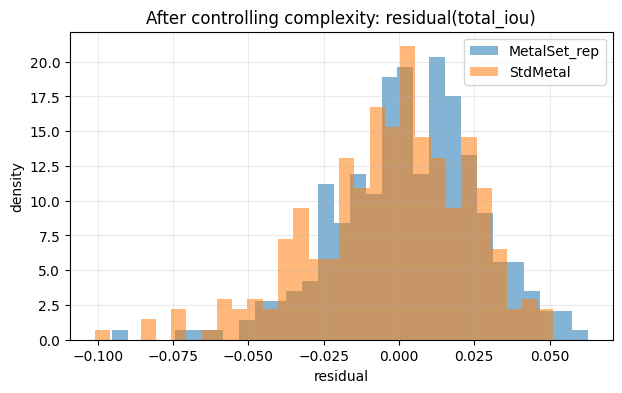

MWU p-value on residuals: 0.012758247398873972
KS  p-value on residuals: 0.021679238194799447


In [21]:
# 회귀로 예측한 iou를 빼고(=복잡도 통제), group별 잔차 분포 비교
df2_n = df2.dropna(subset=["total_iou","area_frac(bin)","compactness(peri^2/area)","edge_density(bin)","components(bin)"]).copy()

# group 제외한 모델로 residual을 만들면 "복잡도만 통제한 후 group 차이"가 남는지 바로 봄
m_nogroup = smf.ols(
    "total_iou ~ Q('area_frac(bin)') + Q('compactness(peri^2/area)') + Q('edge_density(bin)') + Q('components(bin)')",
    data=df2_n
).fit(cov_type="HC3")

df2_n["resid_after_complexity"] = m_nogroup.resid

plt.figure(figsize=(7,4))
a = df2_n[df2_n["set"]=="MetalSet_rep"]["resid_after_complexity"].values
b = df2_n[df2_n["set"]=="StdMetal"]["resid_after_complexity"].values
plt.hist(a, bins=30, alpha=0.55, density=True, label="MetalSet_rep")
plt.hist(b, bins=30, alpha=0.55, density=True, label="StdMetal")
plt.title("After controlling complexity: residual(total_iou)")
plt.xlabel("residual")
plt.ylabel("density")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

print("MWU p-value on residuals:", stats.mannwhitneyu(a,b,alternative="two-sided").pvalue)
print("KS  p-value on residuals:", stats.ks_2samp(a,b).pvalue)


## Step3

In [15]:
def stage_errors_for_row(r):
    bt = load_bin(r["target"])
    bl = load_bin(r["litho"])
    br = load_bin(r["resist"])
    bp = load_bin(r["printed"])

    m_tl = compute_metrics(bt, bl)
    m_lr = compute_metrics(bl, br)
    m_rp = compute_metrics(br, bp)

    return {
        "err_TL": float(1.0 - m_tl["total_iou"]),
        "err_LR": float(1.0 - m_lr["total_iou"]),
        "err_RP": float(1.0 - m_rp["total_iou"]),
    }

def build_stage_df(man_stage, label):
    rows=[]
    for i, r in man_stage.iterrows():
        m = stage_errors_for_row(r)
        m["set"] = label
        m["base_id"] = r["base_id"]
        rows.append(m)
        if (i+1) % 50 == 0:
            print(f"[{label}] {i+1}/{len(man_stage)}")
    return pd.DataFrame(rows)

stage_metal = build_stage_df(man_metal_stage, "MetalSet_rep")
stage_std   = build_stage_df(man_std_stage, "StdMetal")
stage_all = pd.concat([stage_metal, stage_std], ignore_index=True)
stage_all.head()


[MetalSet_rep] 50/271
[MetalSet_rep] 100/271
[MetalSet_rep] 150/271
[MetalSet_rep] 200/271
[MetalSet_rep] 250/271
[StdMetal] 50/271
[StdMetal] 100/271
[StdMetal] 150/271
[StdMetal] 200/271
[StdMetal] 250/271


,err_TL,err_LR,err_RP,set,base_id
0,0.878814,0.881027,0.045660,MetalSet_rep,cell4130
1,0.892847,0.897698,0.043878,MetalSet_rep,cell2675
2,0.881100,0.884808,0.060629,MetalSet_rep,cell15250
3,0.915001,0.927175,0.030675,MetalSet_rep,cell9201
4,0.921226,0.926199,0.028261,MetalSet_rep,cell14893


In [16]:
cols_stage = ["err_TL","err_LR","err_RP"]
res3 = pd.DataFrame([run_tests(stage_all, c) for c in cols_stage])
res3["p_mwu_fdr"] = fdr_bh(res3["p_mwu"].values)
res3["p_ks_fdr"]  = fdr_bh(res3["p_ks"].values)
res3.sort_values("p_mwu").reset_index(drop=True)


,metric,mean_metal,mean_std,diff_mean(metal-std),p_mwu,p_ks,cohens_d,cliffs_delta,p_mwu_fdr,p_ks_fdr
0,err_TL,0.874393,0.740013,0.134380,2.429054e-51,2.785640e-50,1.290567,0.748315,7.287163e-51,8.356919e-50
1,err_LR,0.876173,0.744167,0.132005,4.276102e-48,2.440629e-45,1.263681,0.723397,6.414153e-48,3.660944e-45
2,err_RP,0.057967,0.047181,0.010786,3.195103e-12,2.690026e-09,0.541852,0.345978,3.195103e-12,2.690026e-09


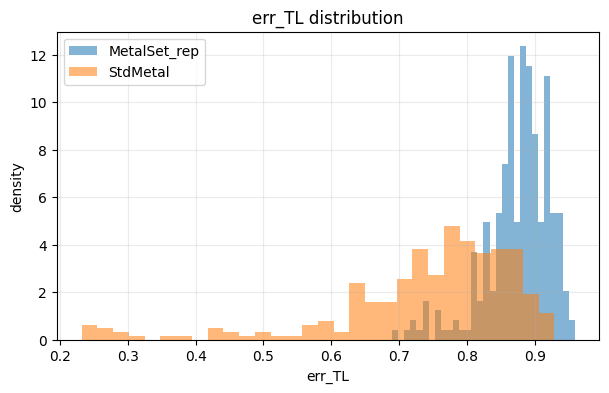

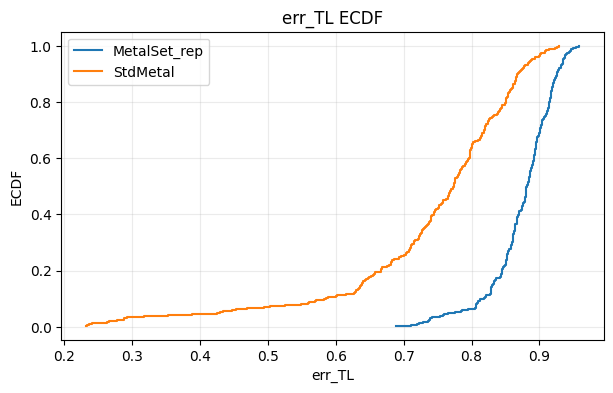

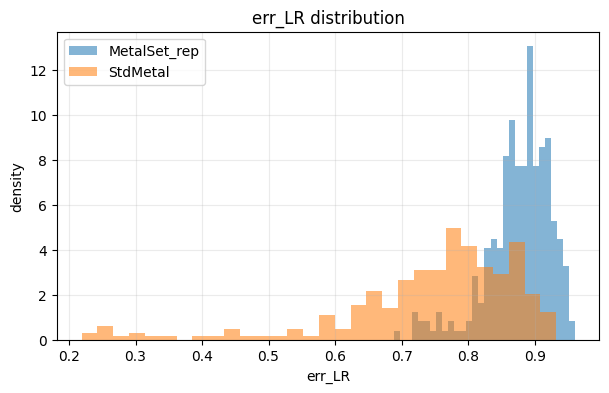

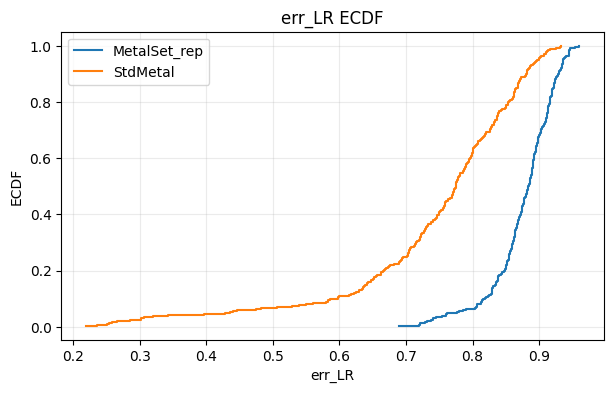

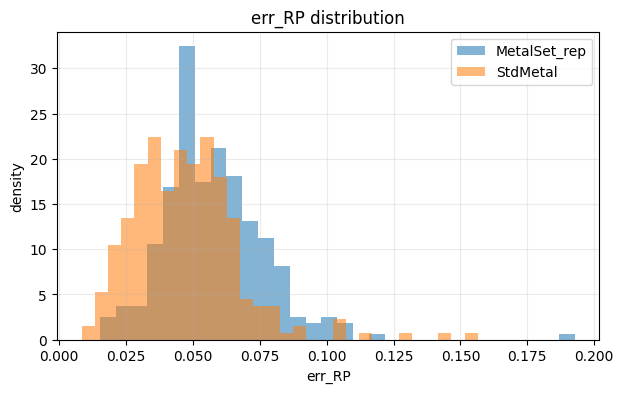

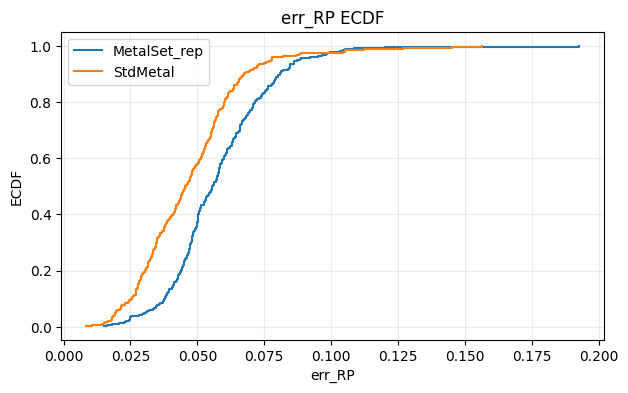

In [17]:
for col in ["err_TL","err_LR","err_RP"]:
    plot_hist_overlay(stage_all, col, bins=30, title=f"{col} distribution")
    plot_ecdf(stage_all, col, title=f"{col} ECDF")


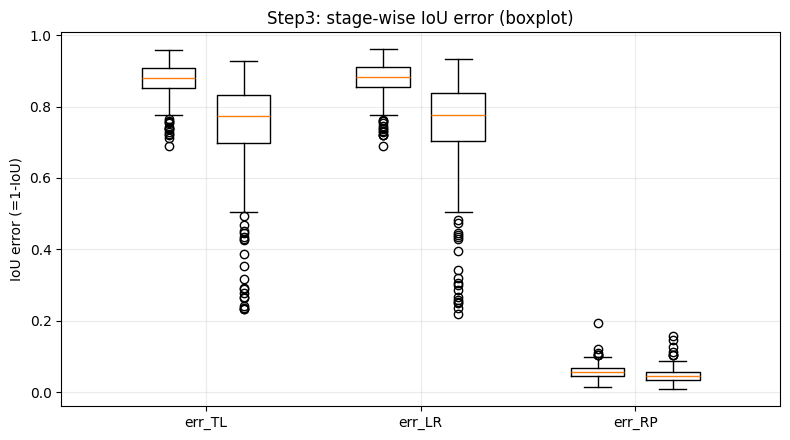

In [22]:
# long-form으로 변환해서 violin/box로 한 장에
st_long = stage_all.melt(id_vars=["set","base_id"], value_vars=["err_TL","err_LR","err_RP"],
                         var_name="stage", value_name="err")

plt.figure(figsize=(8,4.5))
# stage별로 Metal/Std 분포를 나눠서 그리기: 간단 버전은 boxplot 2개씩
stages = ["err_TL","err_LR","err_RP"]
pos = np.arange(len(stages))
width = 0.35

for i, st in enumerate(stages):
    a = st_long[(st_long["stage"]==st) & (st_long["set"]=="MetalSet_rep")]["err"].values
    b = st_long[(st_long["stage"]==st) & (st_long["set"]=="StdMetal")]["err"].values
    # boxplot manual positions
    plt.boxplot(a, positions=[i - width/2], widths=0.25, patch_artist=False)
    plt.boxplot(b, positions=[i + width/2], widths=0.25, patch_artist=False)

plt.xticks(pos, stages)
plt.title("Step3: stage-wise IoU error (boxplot)")
plt.ylabel("IoU error (=1-IoU)")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()
